## Final Project Submission

- Student Names: Jillian Clark, Zach Pollatsek
- Student Pace: Full-Time
- Scheduled Review Date/Time: July 15, 2022
- Instructors: William and Daniel

## Overview and Business Problem

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.

We are a data science consulting company who has been hired by the Tanzanian Ministry of Water to create a model to help classify whether water pumps are functional, functional but in need of repairs, and non-functional. We have been hired to help improve maintenance operations minimze waste of the Ministry's resources and only send out repair teams to pumps that are potentially in need of repairs or non-functional. While we want to maximize accuracy, we also want to maximize recall to ensure the people of Tanzania have access to potable water and few pumps that are non-functional or in need of repairs are over looked.

## Data Understanding

The data is sourced from Taarifa and the Tanzanian Ministry of Water. Data utilized can be found here: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

For the purposes of our evaluation, we are utilizing the Training Set Labels and Training Set Values, which include data from 59,400 pumps. Our cleaned data contains information from 59,028 pumps. 

The following is a list of column names and descriptions:

* `amount_tsh` - Total static head (amount water available to waterpoint)
* `date_recorded` - The date the row was entered
* `funder` - Who funded the well
* `gps_height` - Altitude of the well
* `installer` - Organization that installed the well
* `longitude` - GPS coordinate
* `latitude` - GPS coordinate
* `wpt_name` - Name of the waterpoint if there is one
* `num_private` - 
* `basin` - Geographic water basin
* `subvillage` - Geographic location
* `region` - Geographic location
* `region_code` - Geographic location (coded)
* `district_code` - Geographic location (coded)
* `lga` - Geographic location
* `ward` - Geographic location
* `population` - Population around the well
* `public_meeting` - True/False
* `recorded_by` - Group entering this row of data
* `scheme_management` - Who operates the waterpoint
* `scheme_name` - Who operates the waterpoint
* `permit` - If the waterpoint is permitted
* `construction_year` - Year the waterpoint was constructed
* `extraction_type` - The kind of extraction the waterpoint uses
* `extraction_type_group` - The kind of extraction the waterpoint uses
* `extraction_type_class` - The kind of extraction the waterpoint uses
* `management` - How the waterpoint is managed
* `management_group` - How the waterpoint is managed
* `payment` - What the water costs
* `payment_type` - What the water costs
* `water_quality` - The quality of the water
* `quality_group` - The quality of the water
* `quantity` - The quantity of water
* `quantity_group` - The quantity of water
* `source` - The source of the water
* `source_type` - The source of the water
* `source_class` - The source of the water
* `waterpoint_type` - The kind of waterpoint
* `waterpoint_type_group` - The kind of waterpoint

Our data cleaning steps are shown in the notebook named 'data_cleaning' and our final cleaned dataset is saved as 'final_data.csv'. We import our final dataset here for analysis and modeling.

## Data Analysis

Import Relevant Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as SNS
%matplotlib inline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, \
                            plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

import xgboost
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


from yellowbrick.classifier import ROCAUC
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

In [2]:
# read in cleaned data file
df = pd.read_csv('final_data.csv', index_col=0)
df.head()

,amount_tsh,funder,gps_height,installer,basin,region_code,district_code,public_meeting,scheme_management,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,status_group,age
0,6000.0,Other,1390,Other,Lake Nyasa,11,5,True,VWC,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,23
1,0.0,Other,1399,Other,Lake Victoria,20,2,Unknown,Other,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,12
2,25.0,Other,686,Other,Pangani,21,4,True,VWC,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,13
3,0.0,Unicef,263,Other,Ruvuma / Southern Coast,90,63,True,VWC,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,36
4,0.0,Other,0,Other,Lake Victoria,18,1,True,Unknown,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,22


In [3]:
df.shape

(59028, 19)

In [4]:
# Create our predictors and target
X = df.drop('status_group', axis=1)
y = df.status_group

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
X_train.head()

,amount_tsh,funder,gps_height,installer,basin,region_code,district_code,public_meeting,scheme_management,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,age
34904,5.0,Germany Republi,1376,CES,Pangani,3,5,True,Water Board,True,gravity,water board,pay per bucket,soft,enough,spring,communal standpipe,16
4442,0.0,Other,947,Other,Ruvuma / Southern Coast,10,2,True,VWC,True,gravity,vwc,never pay,soft,enough,river,communal standpipe,35
11884,0.0,Other,227,Other,Ruvuma / Southern Coast,8,3,True,VWC,False,gravity,vwc,never pay,unknown,dry,rainwater harvesting,communal standpipe,20
38675,0.0,Hesawa,1152,DWE,Lake Victoria,19,1,True,Unknown,True,other,vwc,never pay,soft,insufficient,shallow well,other,14
34585,50.0,Government Of Tanzania,248,DWE,Wami / Ruvu,6,3,True,Water Board,False,gravity,water board,pay per bucket,salty,insufficient,dam,communal standpipe,14


In [7]:
# Confirm that out training data set is 3x larger than the testing dataset
print(X_train.shape, X_test.shape)

(44271, 18) (14757, 18)


In [8]:
y.value_counts(normalize=True)

functional                 0.543030
non functional             0.383852
functional needs repair    0.073118
Name: status_group, dtype: float64

It appears that our distribution of target values is relatively uneven; only 7% of our data represents water wells that are functional but need repair. We will run baseline models to determine if we need to use SMOTE to oversample these observations.

# Modeling

### Dummy Model

First, we will create a dummy model that always predicts the most frequent class. In this case, our dummy model will predict that all of the water wells are functional.

In [10]:
# Instantiate our dummy regressor object
dummy = DummyClassifier(strategy='most_frequent')

In [11]:
# Fit the model on our training data
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [12]:
# Inspect the accuracy of our initial dummy model
dummy_score = dummy.score(X_train, y_train)

0.5450294775360846

Our dummy model accuracy of 54.6% reflects the distribution of our target. Thus, if we always predict that a water well is functional, we will achieve 54.6% accuracy.

### Set Up Column Transformer

In [9]:
# Create our sub pipelines for numeric and categorial data
subpipe_num = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False,
                                                    handle_unknown='ignore'))])
subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])
subpipe_smote = SMOTE(sampling_strategy='auto', random_state=42)
subpipe_smote2 = SMOTE(sampling_strategy='minority', random_state=42)

In [10]:
# Include our sub pipelines in a column transformer to OHE our categorial variables and scale our numerical variables.
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [0,2,17]), 
                                     ('subpipe_cat', subpipe_cat, [1,3,4,5,6,7,8,10,11,12,13,14,15,16]), 
                                     ('subpipe_ord', subpipe_ord, [9])])

### Create Pipeline for Simple Models

We will start our process with the creation of simpler classification models to steer us in some direction for future, more complex models. We have decided to initially run logistic regression, K nearest neighbors, and decision tree classifier models all with default hyperparameters (except for a random state, as this allows others to replicate our code). 

In [15]:
# instantiate each pipeline object for the 3 simpler models
# include column transformer as first step in each pipeline
logreg_pipe = Pipeline(steps=[('CT', CT), 
                              ('logreg', LogisticRegression(random_state=42))])

knn_pipe = Pipeline(steps=[('CT', CT), 
                           ('knn', KNeighborsClassifier())])

dtc_pipe = Pipeline(steps=[('CT', CT), 
                           ('dtc', DecisionTreeClassifier(random_state=42))])


In [16]:
# Fit each pipeline to our training data
logreg_pipe.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train)
dtc_pipe.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Get initial accuracy scores for each our our simple classifier models
logreg_score = logreg_pipe.score(X_train, y_train)
knn_score = knn_pipe.score(X_train, y_train)
dtc_score = dtc_pipe.score(X_train, y_train)

In [ ]:
# Print out initial accuracy scores
print(f'Logistic Regression Accuracy: {round(logreg_score * 100, 2)}%')
print(f'KNearestNeighbors Accuracy: {round(knn_score * 100, 2)}%')
print(f'DecisionTree Accuracy: {round(dtc_score * 100, 2)}%')

Our initial numbers appear to be relatively good. We expect our decision tree classifier to be overfit given the high accuracy score. We will dive deeper into more complex models below to maximize our accuracy and recall. Given that our decision tree had the highest initial accuracy (even though it was overfit), we will try a random forest classifier for our first complex model. 

### Random Forest

In [17]:
# Create our random forest pipeline to incorporate column transformer, use default hyperparameters
rfc_pipe = Pipeline(steps=[('CT', CT),
                           ('rfc', RandomForestClassifier(random_state=42))])

In [27]:
# Fit our random forest classifier to the training data
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 17]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 3, 4, 5, 6, 7, 8, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('subpipe_ord',
                                                  Pipeline(steps=[('ord',
                                                    

In [28]:
# Calculate initial accuracy score of random forest with default hyperparameters
rfc_pipe.score(X_train, y_train)

0.9440491518149579

In [29]:
# Perform a cross validation to determine whether or not the model is overfit
avg_rf_cv = np.mean(cross_val_score(estimator=rfc_pipe, X=X_train, y=y_train, cv=5))

In [30]:
avg_rf_cv

0.77890717565598

Given that our cross validation scores were significantly lower than the accuracy score from our single random forest classifier, we can say that this model is overfit to the training data. We will perform a grid search in order to optimize the hyper parameters of this classifier. The main parameter we will use to reduce overfitting is the max depth hyperparameter because this will stop the model from running before it is only comprised of pure nodes

In [ ]:
# create our grid for the grid search parameters
params = {'rfc__n_estimators': [50, 100, 150],
          'rfc__min_samples_split': [2, 10, 50],
          'rfc__max_depth': [5, 10, 15]}

# set up GridSearchCV object
grid_rfc = GridSearchCV(rfc_pipe, param_grid=params, cv=5)

In [ ]:
# fit our grid object for random forests to the training data
grid_rfc.fit(X_train, y_train)

In [ ]:
# find the best hyper parameters from our first grid search
grid_rfc.best_params_

In [ ]:
# calculate the best accuracy score from our first grid search
grid_rfc.best_score_

**From our initial grid search, we attained an accuracy of 78.0% using a max_depth of 15, a min_samples_split of 2, and an n_estimators of 150.** Next, we will play with the max depth hyper parameter a bit more since the best value was at the top of our range in the initial grid search


In [ ]:
pd.DataFrame(grid_rfc.cv_results_)

Based on our initial grid search results, we can infer that a larger max depth is needed to improve accuracy. 

In [ ]:
# create our grid for the grid search parameters
params2 = {'rfc__n_estimators': [50, 100, 150],
           'rfc__max_depth': [15, 25, 50]}

# set up GridSearchCV object
grid_rfc2 = GridSearchCV(rfc_pipe, param_grid=params2, cv=5)

In [ ]:
# fit our grid object with parameter updates for random forests to the training data
grid_rfc2.fit(X_train, y_train)

In [ ]:
# find the best hyper parameters from our second grid search
grid_rfc2.best_params_

In [ ]:
# calculate the best accuracy score from our second grid search
grid_rfc2.best_score_

**From our second grid search, we attained an accuracy of 78.9% using a max_depth of 25 and an n_estimators of 150.** We can increase the maximum end of our range for the number of decision trees in the random forest as well as the max depth given that the best hyperparameters were the maximum values for each range.

In [ ]:
pd.DataFrame(grid_rfc2.cv_results_)

Based on our new grid search, we can see that a maximum depth greater than 15 but less than 50 is ideal. We will also try running the grid search with a higher number of trees in the random forest to improve accuracy.

In [ ]:
# create our grid for the grid search parameters
params3 = {'rfc__n_estimators': [100, 150, 200],
           'rfc__max_depth': [20, 25, 30]}

# set up GridSearchCV object
grid_rfc3 = GridSearchCV(rfc_pipe, param_grid=params3, cv=5)

In [ ]:
# Fit the grid object to our training data with updated grid params for n_estimators and max_depth
grid_rfc3.fit(X_train, y_train)

In [ ]:
# find the best hyper parameters from our third grid search
grid_rfc3.best_params_

In [ ]:
# calculate the best accuracy score from our third grid search
grid_rfc3.best_score_

**From our third grid search, we attained an accuracy of 79.3% using a max_depth of 20 and an n_estimators of 200.** 

In [ ]:
pd.DataFrame(grid_rfc3.cv_results_)

In [ ]:
# create our grid for the grid search parameters
params4 = {'rfc__n_estimators': [100, 150],
           'rfc__max_depth': [18, 20, 22],
           'rfc__max_features': ['auto', 'sqrt', 0.2]}

# set up GridSearchCV object
grid_rfc4 = GridSearchCV(rfc_pipe, param_grid=params4, cv=5)

In [ ]:
# Fit the grid object to our training data with updated grid params for n_estimators, max_depth, and max_features
grid_rfc4.fit(X_train, y_train)

In [ ]:
# find the best hyper parameters from our fourth grid search
grid_rfc4.best_params_

In [ ]:
# calculate the best accuracy score from our fourth grid search
grid_rfc4.best_score_

**From our fourth grid search, we attained an accuracy of 79.3% using a max_depth of 20, a max_features of 0.2, and an n_estimators of 150.** 

In [ ]:
pd.DataFrame(grid_rfc4.cv_results_)

In [ ]:
# create our massive grid for the grid search parameters
params5 = {'rfc__n_estimators': [125, 150, 175],
           'rfc__max_depth': [15, 20, 25],
           'rfc__max_features': ['sqrt', 0.1, 0.2, 0.5],
           'rfc__min_samples_leaf': [25, 50, 100],
           'rfc__min_impurity_decrease': [0, 0.025, 0.05, 0.075, 0.1],
           'rfc__criterion': ['gini', 'entropy', 'log_loss']}

# set up GridSearchCV object
#grid_rfc5 = GridSearchCV(rfc_pipe, param_grid=params5, cv=5)

In [ ]:
# Fit the grid search object to our training data to check numerous hyperparameters.
#grid_rfc5.fit(X_train, y_train)

In [ ]:
#grid_rfc5.best_params_

In [ ]:
#grid_rfc5.best_score_

**From our fifth grid search, we attained an accuracy of 77.5% using a max_depth of 25, a max_features of 0.5, an entropy criterion, a minimum impurity decrease of 0, a minimum samples per leaf of 25, and an n_estimators of 175.** 

In [ ]:
#pd.DataFrame(grid_rfc5.cv_results_)

In [ ]:
# create our grid for the grid search parameters
params6 = {'rfc__n_estimators': [100, 150, 200],
           'rfc__max_depth': [18, 20, 22],
           'rfc__max_features': [0.1, 0.2, 0.5]}

# set up GridSearchCV object
grid_rfc6 = GridSearchCV(rfc_pipe, param_grid=params6, cv=5)

In [ ]:
# Fit our sixth grid search on the training data
grid_rfc6.fit(X_train, y_train)

In [ ]:
grid_rfc6.best_params_

In [ ]:
grid_rfc6.best_score_

In [ ]:
rf_preds6 = grid_rfc6.predict(X_train)

In [ ]:
grid_rfc6.score(X_train, y_train)

In [ ]:
plot_confusion_matrix(grid_rfc6, X_train, y_train);

In [ ]:
print(classification_report(y_train, rf_preds6))

**From our sixth grid search, we attained an accuracy of 79.3% using a max_depth of 20, a max_features of 0.1, and an n_estimators of 200.** 

In [ ]:
pd.DataFrame(grid_rfc6.cv_results_)

### Random Forest with SMOTE

In [14]:
# Create our random forest pipeline to incorporate column transformer
rfc_pipe_sm = ImPipeline(steps=[('CT', CT),
                                ('sm', subpipe_smote),
                                ('rfc', RandomForestClassifier(random_state=42))])

In [ ]:
# Fit training data to our new random forest pipe using SMOTE to over sample minority classes
rfc_pipe_sm.fit(X_train, y_train)

In [ ]:
rfc_pipe_sm.score(X_train, y_train)

In [ ]:
cross_val_score(rfc_pipe_sm, X_train, y_train)

In [ ]:
plot_confusion_matrix(rfc_pipe_sm, X_train, y_train);

In [ ]:
print(classification_report(y_train, rfc_pipe_sm.predict(X_train)))

In [14]:
# create our grid for the grid search parameters
params = {'rfc__n_estimators': [50, 100, 150],
          'rfc__min_samples_split': [2, 10, 50],
          'rfc__max_depth': [5, 10, 15]}

# set up GridSearchCV object
grid_rfc_sm = GridSearchCV(rfc_pipe_sm, param_grid=params, cv=5)

In [19]:
grid_rfc_sm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          17]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                            

In [25]:
grid_rfc_sm.best_params_

{'rfc__max_depth': 15, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 150}

In [27]:
grid_rfc_sm.best_score_

0.7430147736982279

In [29]:
print(classification_report(y_train, grid_rfc_sm.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.85      0.83      0.84     24129
functional needs repair       0.36      0.78      0.50      3230
         non functional       0.91      0.75      0.82     16912

               accuracy                           0.79     44271
              macro avg       0.71      0.79      0.72     44271
           weighted avg       0.84      0.79      0.81     44271



In [15]:
# create our grid for the grid search parameters
params2 = {'rfc__n_estimators': [50, 100, 150],
           'rfc__max_depth': [15, 25, 50]}

# set up GridSearchCV object
grid_rfc_sm2 = GridSearchCV(rfc_pipe_sm, param_grid=params2, cv=5)

In [20]:
grid_rfc_sm2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          17]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                            

In [30]:
grid_rfc_sm2.best_params_

{'rfc__max_depth': 25, 'rfc__n_estimators': 150}

In [31]:
grid_rfc_sm2.best_score_

0.7654899679434892

In [32]:
print(classification_report(y_train, grid_rfc_sm2.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.94      0.92      0.93     24129
functional needs repair       0.59      0.88      0.71      3230
         non functional       0.96      0.90      0.93     16912

               accuracy                           0.91     44271
              macro avg       0.83      0.90      0.85     44271
           weighted avg       0.92      0.91      0.91     44271



In [16]:
# create our grid for the grid search parameters
params3 = {'rfc__n_estimators': [100, 150, 200],
           'rfc__max_depth': [20, 25, 30]}

# set up GridSearchCV object
grid_rfc_sm3 = GridSearchCV(rfc_pipe_sm, param_grid=params3, cv=5)

In [21]:
grid_rfc_sm3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          17]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                            

In [33]:
grid_rfc_sm3.best_params_

{'rfc__max_depth': 25, 'rfc__n_estimators': 200}

In [34]:
grid_rfc_sm3.best_score_

0.765828782545177

In [36]:
print(classification_report(y_train, grid_rfc_sm3.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.94      0.92      0.93     24129
functional needs repair       0.59      0.89      0.71      3230
         non functional       0.96      0.90      0.93     16912

               accuracy                           0.91     44271
              macro avg       0.83      0.90      0.85     44271
           weighted avg       0.92      0.91      0.91     44271



In [17]:
# create our grid for the grid search parameters
params4 = {'rfc__n_estimators': [100, 150],
           'rfc__max_depth': [18, 20, 22],
           'rfc__max_features': ['auto', 'sqrt', 0.2]}

# set up GridSearchCV object
grid_rfc_sm4 = GridSearchCV(rfc_pipe_sm, param_grid=params4, cv=5)

In [22]:
grid_rfc_sm4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          17]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                            

In [37]:
grid_rfc_sm4.best_params_

{'rfc__max_depth': 22, 'rfc__max_features': 0.2, 'rfc__n_estimators': 150}

In [38]:
grid_rfc_sm4.best_score_

0.7668451982897923

In [39]:
print(classification_report(y_train, grid_rfc_sm4.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.92      0.91      0.91     24129
functional needs repair       0.56      0.86      0.68      3230
         non functional       0.95      0.87      0.91     16912

               accuracy                           0.89     44271
              macro avg       0.81      0.88      0.83     44271
           weighted avg       0.91      0.89      0.90     44271



In [18]:
# create our grid for the grid search parameters
params5 = {'rfc__n_estimators': [100, 150, 200],
           'rfc__max_depth': [18, 20, 22],
           'rfc__max_features': [0.1, 0.2, 0.5]}

# set up GridSearchCV object
grid_rfc_sm5 = GridSearchCV(rfc_pipe_sm, param_grid=params5, cv=5)

In [23]:
grid_rfc_sm5.fit(X_train, y_train)

KeyboardInterrupt: 

### Combining XGBoost with RF using Stacking

In [36]:
# Set up random forest classifier to be used in stacking classifier
rfc_pipe_stack = ImPipeline(steps=[('CT', CT),
                                   ('sm', subpipe_smote),
                                   ('rfc', RandomForestClassifier(random_state=42))])

In [37]:
# Set up XGBoost to be used in stacking classifier
xgb_pipe_stack = ImPipeline(steps=[('CT', CT), 
                                   ('sm', subpipe_smote),
                                   ('XGB', XGBClassifier())])

In [38]:
# Instantiate initial stacking classifier object with our two models
stack = StackingClassifier(estimators=[('RandForest', rfc_pipe_stack),
                                       ('XGBoost', xgb_pipe_stack)],
                           verbose=3)

In [39]:
# Fit the stacking classifier to our training data
stack.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished


StackingClassifier(estimators=[('RandForest',
                                Pipeline(steps=[('CT',
                                                 ColumnTransformer(transformers=[('subpipe_num',
                                                                                  Pipeline(steps=[('ss',
                                                                                                   StandardScaler())]),
                                                                                  [0,
                                                                                   2,
                                                                                   17]),
                                                                                 ('subpipe_cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(

In [41]:
stack.score(X_train, y_train)

0.8807571547965937

In [42]:
avg_stack_cv = np.mean(cross_val_score(estimator=stack, X=X_train, y=y_train, cv=5))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

In [43]:
avg_stack_cv

0.7916695315958728

In [36]:
# set up grid search for stacking classifier
stack_params = {
    'RandForest__rfc__n_estimators': [150, 200],
    'RandForest__rfc__max_depth': [15, 20, 25],
    'RandForest__rfc__max_features': [0.1, 0.2], 
    'XGBoost__XGB__max_depth': [5, 10, 20],
    'XGBoost__XGB__booster': ['gbtree', 'gblinear'],
    'XGBoost__XGB__eta': [0.3, 0.5]
}

In [37]:
#stack_grid = GridSearchCV(estimator=stack, param_grid=stack_params, n_jobs=-1, cv=5, verbose=3)

In [48]:
# Had to interrupt grid search because it had been running for over 1.5 days. Pulled some hyperparameters that led to 
# our best accuracy scores 
#stack_grid.fit(X_train, y_train)

In [64]:
# Set up random forest classifier to be used in stacking classifier
rfc_pipe_stack2 = ImPipeline(steps=[('CT', CT),
                                    ('sm', subpipe_smote),
                                    ('rfc', RandomForestClassifier(n_estimators=200, 
                                                                   max_depth=20, 
                                                                   max_features=0.1, 
                                                                   random_state=42))])

In [65]:
# Set up XGBoost to be used in stacking classifier
xgb_pipe_stack2 = ImPipeline(steps=[('CT', CT), 
                                    ('sm', subpipe_smote),
                                    ('XGB', XGBClassifier(max_depth=10, 
                                                          learning_rate=0.3, 
                                                          booster='gbtree'))])

In [66]:
# Instantiate initial stacking classifier object with our two models
stack2 = StackingClassifier(estimators=[('RandForest', rfc_pipe_stack2),
                                        ('XGBoost', xgb_pipe_stack2)],
                            verbose=3)

In [67]:
stack2.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.1min finished


StackingClassifier(estimators=[('RandForest',
                                Pipeline(steps=[('CT',
                                                 ColumnTransformer(transformers=[('subpipe_num',
                                                                                  Pipeline(steps=[('ss',
                                                                                                   StandardScaler())]),
                                                                                  [0,
                                                                                   2,
                                                                                   17]),
                                                                                 ('subpipe_cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse=False))]),
                                                                                  [1,
                                                                                   3,
                                                                                   4,
                                                                                   5,
                                                                                   6,
                                                                                   7,
                                                                                   8,
                                                                                   10,
                                                                                   11,
                                                                                   12,
                                                                                   13,
                                                                                   14,
                                                                                   15,
                                                                                   16]),
                                                                                 ('subpipe_ord',
                                                                                  Pipeline(steps=[('ord',
                                                                                                   OrdinalEncoder(...
                                                               interaction_constraints=None,
                                                               learning_rate=0.3,
                                                               max_delta_step=None,
                                                               max_depth=10,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None,
                                                               scale_pos_weight=None,
                                                               subsample=None,
                                                               tree_meth

In [22]:
stack2.score(X_train, y_train)

0.8759458787919857

In [23]:
cross_val_score(stack2, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

KeyboardInterrupt: 

In [24]:
stack2.score(X_test, y_test)

0.7895913803618622

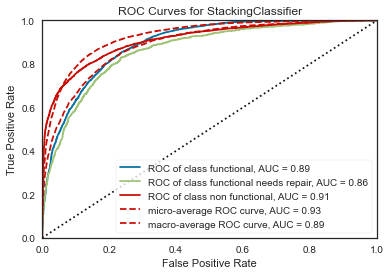

In [68]:
model = stack2
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="images/ROC.png", dpi=300);  

In [75]:
from yellowbrick.style import set_palette
set_palette(['green', 'orange', 'red'])

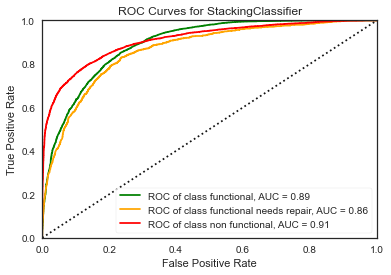

In [76]:
model = stack2
visualizer = ROCAUC(model, micro=False, macro=False)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="images/ROC2.png", dpi=300);  

In [47]:
print(classification_report(y_train, stack2.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.85      0.96      0.90     24129
functional needs repair       0.73      0.44      0.55      3230
         non functional       0.94      0.84      0.89     16912

               accuracy                           0.88     44271
              macro avg       0.84      0.75      0.78     44271
           weighted avg       0.88      0.88      0.87     44271



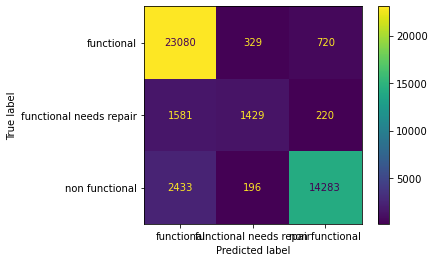

In [50]:
plot_confusion_matrix(stack2, X_train, y_train);

### XGBoost Prequel

In [31]:
# Instantiate our default XGB pipeline
xgb_pipe = ImPipeline(steps=[('CT', CT), 
                             ('XGB', XGBClassifier())])


In [32]:
# Fit the xgb pipeline to our training data
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 17]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 3, 4, 5, 6, 7, 8, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('subpipe_ord',
                                                  Pipeline(steps=[('ord',
                                                    

In [ ]:
training_preds = xgb_pipe.predict(X_train)

In [ ]:
print(classification_report(y_train, training_preds))

In [ ]:
plot_confusion_matrix(xgb_pipe, X_train, y_train);

In [33]:
xgb_pipe.score(X_train, y_train)

0.8180072733843825

In [34]:
avg_xgb_cv = np.mean(cross_val_score(xgb_pipe, X_train, y_train))

In [35]:
avg_xgb_cv

0.7860224991221544

### XGBoost


Here, we run an inital XGBoost model.

In [52]:
from xgboost import XGBClassifier

In [53]:
# Instantiate XGBClassifier
XGB_pipe = ImPipeline(steps=[('CT', CT), 
                           ('sm', subpipe_smote),
                            ('XGB', XGBClassifier())])

In [ ]:
#Fit XGBClassifier

In [20]:
XGB_pipe.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 17]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 3, 4, 5, 6, 7, 8, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('subpipe_ord',
                                                  Pipeline(steps=[('ord',
                                                    

In [21]:
# Predict on training and test sets
training_preds = XGB_pipe.predict(X_train)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average= None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print (training_recall)

Training Accuracy: 78.42%
[0.82788346 0.62600619 0.75212867]


In [1]:
#Training Accuracy: 78.42%
#Recall values: .8279, .6260, .7521

In [22]:
# create our massive grid for the grid search parameters
paramsXGB = {
    'XGB__learning_rate': [0.1, 0.2],
    'XGB__max_depth': range(3, 10, 2),
    'XGB__min_child_weight': range(1, 8, 2),
    'XGB__gamma': [0, .1, .2],
    'XGB__subsample': [.5, .75, 1]
}

Here we create a grid search to identify the best parameters for an XGBoost model of the parameters specified in paramsXGB.

In [23]:
grid_XGB = GridSearchCV(XGB_pipe, param_grid=paramsXGB, cv=5, verbose=3, n_jobs=-1)

#Fit grid search object to our training data to check the hyper parameters


In [24]:
grid_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.1min
/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 73.3min
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed: 138.3min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 214.1min
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed: 313.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 408.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          17]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                            

In [33]:
best_parameters = grid_XGB.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_XGB.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
XGB__gamma: 0.1
XGB__learning_rate: 0.2
XGB__max_depth: 9
XGB__min_child_weight: 1
XGB__subsample: 0.75
Training Accuracy: 82.33%
[0.86116292 0.67956656 0.79677152]


In [34]:
#Grid Search found the following optimal parameters: 
#XGB__gamma: 0.1
#XGB__learning_rate: 0.2
#XGB__max_depth: 9
#XGB__min_child_weight: 1
#XGB__subsample: 0.75
#Training Accuracy: 82.33%
#Traing Recall: [0.86116292 0.67956656 0.79677152]

In [35]:
##XGBoost using optimal parameters improved overall accuracy and 
#recall values

In [74]:
print(classification_report(y_train, training_preds))

                         precision    recall  f1-score   support

             functional       0.86      0.86      0.86     24129
functional needs repair       0.44      0.68      0.54      3230
         non functional       0.89      0.80      0.84     16912

               accuracy                           0.82     44271
              macro avg       0.73      0.78      0.75     44271
           weighted avg       0.84      0.82      0.83     44271



In [2]:
#Created pipeline using Best Params from grid search

In [75]:
XGB_pipe2 = ImPipeline(steps=[('CT', CT), 
                           ('sm', subpipe_smote),
                            ('XGB', XGBClassifier(gamma=.1, learning_rate=.2, max_depth=9,
                                                 min_child_weight=1, subsample=.75))])

In [76]:
XGB_pipe2.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 17]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 3, 4, 5, 6, 7, 8, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('subpipe_ord',
                                                  Pipeline(steps=[('ord',
                                                    

In [77]:
XGB_pipe2.score(X_train, y_train)

0.8233154886946308

In [78]:
cross_val_score(estimator=XGB_pipe2, X=X_train, y=y_train, cv=5)

array([0.75776398, 0.76632031, 0.77095098, 0.77580754, 0.76586853])

In [79]:
training_preds2 = XGB_pipe2.predict(X_train)

In [80]:
print(classification_report(y_train, training_preds2))

                         precision    recall  f1-score   support

             functional       0.86      0.86      0.86     24129
functional needs repair       0.44      0.68      0.54      3230
         non functional       0.89      0.80      0.84     16912

               accuracy                           0.82     44271
              macro avg       0.73      0.78      0.75     44271
           weighted avg       0.84      0.82      0.83     44271



In [3]:
#plotting confusion matrix to see if our functional needs repairs are being
#predicted as functional or non-functional; if predicted as non-functional we are 
#OK with that because repair team would go look at and find it needs repairs

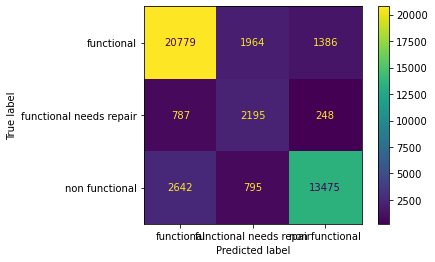

In [94]:
plot_confusion_matrix(XGB_pipe2, X_train, y_train);

In [86]:
##will run the optimal paramenters with subpipe_smote2, which changes
#sampling strategy to minority

In [87]:
XGB_pipe3 = ImPipeline(steps=[('CT', CT), 
                           ('sm', subpipe_smote2),
                            ('XGB', XGBClassifier(gamma=.1, learning_rate=.2, max_depth=9,
                                                 min_child_weight=1, subsample=.75))])

In [88]:
XGB_pipe3.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 17]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 3, 4, 5, 6, 7, 8, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('subpipe_ord',
                                                  Pipeline(steps=[('ord',
                                                    

In [89]:
XGB_pipe3.score(X_train, y_train)

0.8221183167310429

In [90]:
cross_val_score(estimator=XGB_pipe3, X=X_train, y=y_train, cv=5)

array([0.76115189, 0.76744974, 0.77196747, 0.77422634, 0.76462616])

In [91]:
training_preds3 = XGB_pipe3.predict(X_train)

In [92]:
print(classification_report(y_train, training_preds3))

                         precision    recall  f1-score   support

             functional       0.85      0.88      0.86     24129
functional needs repair       0.43      0.68      0.53      3230
         non functional       0.92      0.77      0.84     16912

               accuracy                           0.82     44271
              macro avg       0.73      0.78      0.74     44271
           weighted avg       0.84      0.82      0.83     44271



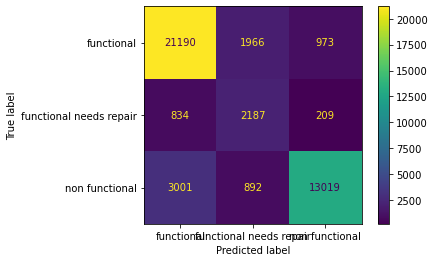

In [93]:
plot_confusion_matrix(XGB_pipe3, X_train, y_train);

In [95]:
##We actually see more predictions for functional where the true label is non-functional or functional needs repair;
##because of this we would want to utilize XGB_pipe2 over XGB_pipe3

In [54]:
#Running grid search to see if changing k_neighbors for SMOTE effects results.

In [55]:
paramsXGB4 = {
    'sm__k_neighbors': [3, 5, 11],
}

In [56]:
XGB_pipe4 = ImPipeline(steps=[('CT', CT), 
                           ('sm', subpipe_smote),
                            ('XGB', XGBClassifier(gamma=.1, learning_rate=.2, max_depth=9,
                                                 min_child_weight=1, subsample=.75))])

In [59]:
grid_XGB4 = GridSearchCV(XGB_pipe4, param_grid=paramsXGB4, cv=5, verbose=3)

In [60]:
grid_XGB4.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] sm__k_neighbors=3 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... sm__k_neighbors=3, score=0.752, total=  45.4s
[CV] sm__k_neighbors=3 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.4s remaining:    0.0s


[CV] ................... sm__k_neighbors=3, score=0.762, total=  46.7s
[CV] sm__k_neighbors=3 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] ................... sm__k_neighbors=3, score=0.764, total=  47.2s
[CV] sm__k_neighbors=3 ...............................................
[CV] ................... sm__k_neighbors=3, score=0.769, total=  48.2s
[CV] sm__k_neighbors=3 ...............................................
[CV] ................... sm__k_neighbors=3, score=0.762, total=  44.2s
[CV] sm__k_neighbors=5 ...............................................
[CV] ................... sm__k_neighbors=5, score=0.758, total=  45.3s
[CV] sm__k_neighbors=5 ...............................................
[CV] ................... sm__k_neighbors=5, score=0.766, total=  46.0s
[CV] sm__k_neighbors=5 ...............................................
[CV] ................... sm__k_neighbors=5, score=0.771, total=  47.5s
[CV] sm__k_neighbors=5 ...............................................
[CV] ................... sm__k_neighbors=5, score=0.776, total=  47.5s
[CV] sm__k_neighbors=5 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 12.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 2,
                                                                          17]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                            

In [62]:
best_parameters4 = grid_XGB4.best_params_

In [63]:
best_parameters4

{'sm__k_neighbors': 11}

In [64]:
grid_XGB4.score(X_train, y_train)

0.8303855797248764

In [72]:
#created new subpipe using best parameter: k_neighbors: 11

In [66]:
subpipe_smote3 = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=11)

In [73]:
#created new pipeline with new subpipe_smote3

In [67]:
XGB_pipe5 = ImPipeline(steps=[('CT', CT), 
                           ('sm', subpipe_smote3),
                            ('XGB', XGBClassifier(gamma=.1, learning_rate=.2, max_depth=9,
                                                 min_child_weight=1, subsample=.75))])

In [69]:
XGB_pipe5.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [0, 2, 17]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [1, 3, 4, 5, 6, 7, 8, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('subpipe_ord',
                                                  Pipeline(steps=[('ord',
                                                    

In [70]:
XGB_pipe5.score(X_train, y_train)

0.8303855797248764

In [71]:
cross_val_score(estimator=XGB_pipe5, X=X_train, y=y_train, cv=5)

array([0.76781479, 0.77287102, 0.77264513, 0.77851818, 0.76880506])

In [74]:
training_preds5 = XGB_pipe5.predict(X_train)

In [75]:
print(classification_report(y_train, training_preds5))

                         precision    recall  f1-score   support

             functional       0.85      0.88      0.87     24129
functional needs repair       0.48      0.61      0.54      3230
         non functional       0.89      0.80      0.84     16912

               accuracy                           0.83     44271
              macro avg       0.74      0.76      0.75     44271
           weighted avg       0.84      0.83      0.83     44271



## Visualizations

In [39]:
y.value_counts()

functional                 32054
non functional             22658
functional needs repair     4316
Name: status_group, dtype: int64

In [72]:
y_values = 32054, 22658, 4316

In [40]:
%matplotlib inline

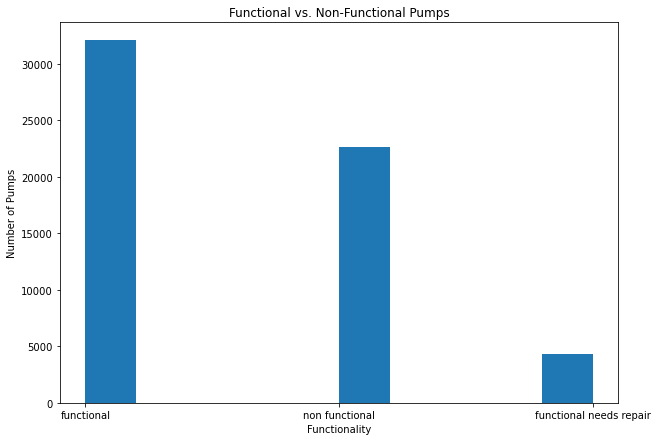

In [44]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y)
plt.title('Functional vs. Non-Functional Pumps')
plt.xlabel('Functionality')
plt.ylabel('Number of Pumps');
 
# Show plot
plt.show()

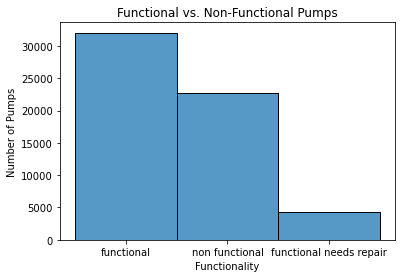

In [22]:
SNS.histplot(data=y).set(
    title='Functional vs. Non-Functional Pumps', xlabel ='Functionality', ylabel= 'Number of Pumps');


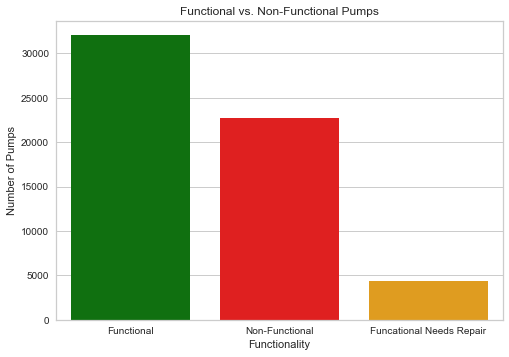

In [21]:
ax = SNS.countplot(x=y, palette= ['green', 'red', 'orange']).set(
    title='Functional vs. Non-Functional Pumps', xlabel ='Functionality', ylabel= 'Number of Pumps', 
    xticklabels=('Functional', 'Non-Functional', 'Funcational Needs Repair'));
plt.savefig("images/FunctionalvNonFunctional.png", dpi=300)


In [45]:
y.value_counts().values

array([32054, 22658,  4316])

<ipython-input-61-dce6acf102c2>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


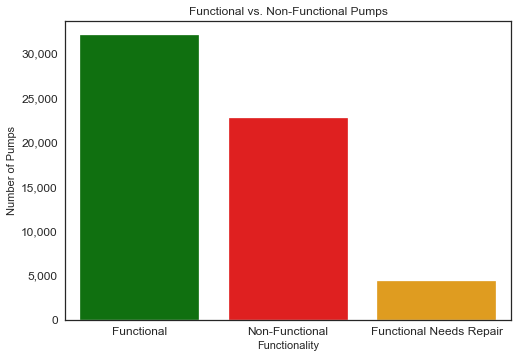

In [61]:
SNS.set_style("white")
SNS.barplot(x=['Functional', 'Non-Functional', 'Functional Needs Repair'], y=[32054, 22658, 4316], palette= ['green', 'red', 'orange']).set(
    title='Functional vs. Non-Functional Pumps', xlabel ='Functionality', ylabel= 'Number of Pumps')
plt.xticks(size=12)
plt.yticks(size=12)
plt.ticklabel_format(axis='y', style='plain')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel = 'Functionality';
plt.savefig("images/FunctionalvNonFunctional2.png", dpi=300)

## Stacking Classifier

In [35]:
rfc_pipe_stack3 = ImPipeline(steps=[('CT', CT),
                                    ('sm', subpipe_smote),
                                    ('rfc', RandomForestClassifier(n_estimators=150,
                                                                   max_depth=25,
                                                                   max_features=0.2,
                                                                   random_state=42))])

In [36]:
xgb_pipe_stack3 = ImPipeline(steps=[('CT', CT), 
                                    ('sm', subpipe_smote),
                                    ('XGB', XGBClassifier(max_depth=5,
                                                          learning_rate=0.3,
                                                          booster='gbtree'))])

In [40]:
stack3 = StackingClassifier(estimators=[('RandForest', rfc_pipe_stack3),
                                        ('XGBoost', xgb_pipe_stack3)],
                            verbose=3)

In [41]:
stack3.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished


StackingClassifier(estimators=[('RandForest',
                                Pipeline(steps=[('CT',
                                                 ColumnTransformer(transformers=[('subpipe_num',
                                                                                  Pipeline(steps=[('ss',
                                                                                                   StandardScaler())]),
                                                                                  [0,
                                                                                   2,
                                                                                   17]),
                                                                                 ('subpipe_cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(

In [42]:
stack3.score(X_train, y_train)

0.8788597501750581

In [43]:
cross_val_score(estimator=stack3, X=X_train, y=y_train, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


[CV] .................................... , score=0.790, total= 4.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


[CV] .................................... , score=0.788, total= 4.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


[CV] .................................... , score=0.792, total= 4.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


[CV] .................................... , score=0.799, total= 4.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


[CV] .................................... , score=0.791, total= 4.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.0min finished


array([0.79017504, 0.78834425, 0.79241021, 0.79918681, 0.79105489])

In [48]:
#array([0.79017504, 0.78834425, 0.79241021, 0.79918681, 0.79105489])

In [47]:
np.mean([0.79017504, 0.78834425, 0.79241021, 0.79918681, 0.79105489])

0.79223424

In [49]:
print(classification_report(y_train, stack2.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.86      0.96      0.90     24129
functional needs repair       0.72      0.38      0.50      3230
         non functional       0.94      0.86      0.90     16912

               accuracy                           0.88     44271
              macro avg       0.84      0.73      0.77     44271
           weighted avg       0.88      0.88      0.87     44271



In [50]:
#worse accuracy cross-val mean and worse recall than other stack

# Final Model

In [16]:
# Instantiate final stacking classifier object with our two models
final_model = StackingClassifier(estimators=[('RandForest', rfc_pipe_stack2),
                                             ('XGBoost', xgb_pipe_stack2)],
                                 verbose=3)

In [17]:
# fit our final model to the training data
final_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.8min finished


StackingClassifier(estimators=[('RandForest',
                                Pipeline(steps=[('CT',
                                                 ColumnTransformer(transformers=[('subpipe_num',
                                                                                  Pipeline(steps=[('ss',
                                                                                                   StandardScaler())]),
                                                                                  [0,
                                                                                   2,
                                                                                   17]),
                                                                                 ('subpipe_cat',
                                                                                  Pipeline(steps=[('ohe',
                                                                                                   OneHotEncoder(

In [80]:
final_model.score(X_train, y_train)

0.8762395247453186

In [19]:
final_model.score(X_test, y_test)

0.7899302026157078

In [20]:
print(classification_report(y_test, final_model.predict(X_test)))

                         precision    recall  f1-score   support

             functional       0.78      0.89      0.83      7925
functional needs repair       0.54      0.30      0.38      1086
         non functional       0.84      0.74      0.79      5746

               accuracy                           0.79     14757
              macro avg       0.72      0.64      0.67     14757
           weighted avg       0.78      0.79      0.78     14757



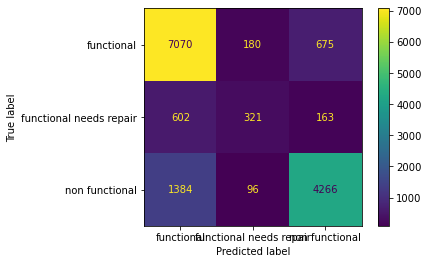

In [22]:
plot_confusion_matrix(final_model, X_test, y_test);

In [23]:
plot_roc_curve(final_model, X_test, y_test)

ValueError: StackingClassifier should be a binary classifier

### Final Model Results:

**Training Accuracy: 88% <br>
Training Recall: 75%**

**Test Accuracy: 79% <br>
Test Recall: 64%**

In [44]:
results_dict = {'Dummy Model': dummy_score, 
                'Random Forest': avg_rf_cv, 
                'XGBoost': avg_xgb_cv, 
                'Stacking Classifier': avg_stack_cv}

In [51]:
dict_keys = list(results_dict.keys())
dict_values = list(results_dict.values())

In [59]:
for i, v in enumerate(results_dict):
    print(i, v)

0 Dummy Model
1 Random Forest
2 XGBoost
3 Stacking Classifier


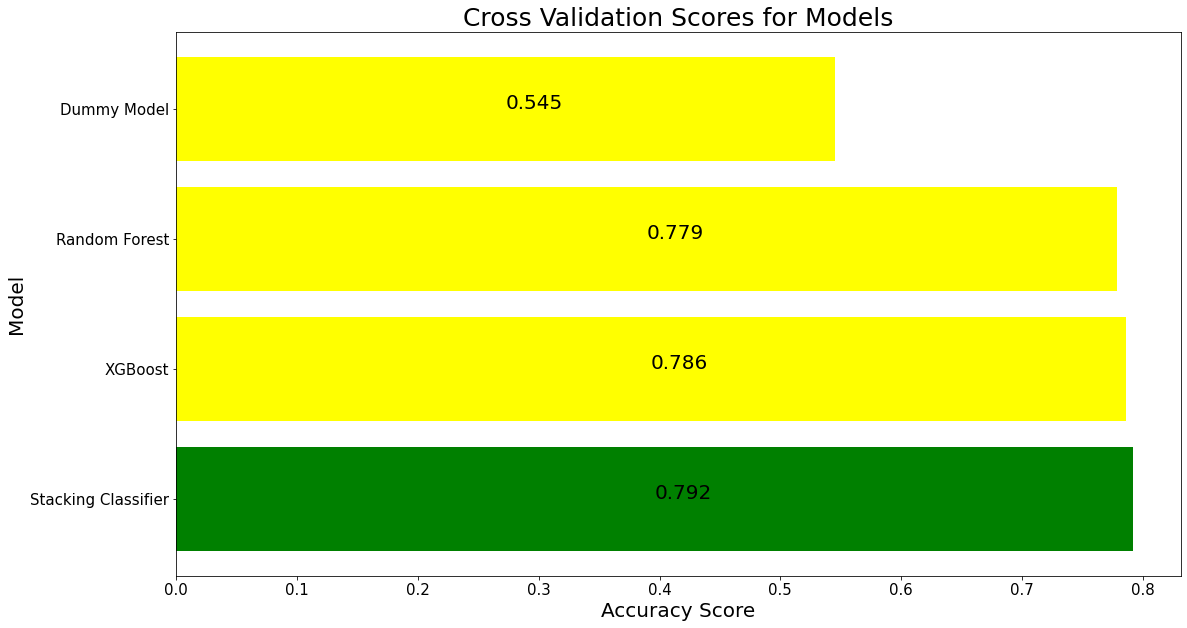

In [93]:
fig, ax = plt.subplots(figsize=(18,10))

ax.barh(dict_keys, dict_values, align='center', color=['yellow', 'yellow', 'yellow', 'green'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy Score', fontsize=20)
ax.set_ylabel('Model', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Cross Validation Scores for Models', fontsize=25)
for i, v in enumerate(dict_values):
    ax.text(v/2, i, str(round(v, 3)), color='black', fontsize=20)


plt.savefig('images/ModelAccuracyScores.png', dpi=400, bbox_inches='tight')

In [105]:
conf_mat = confusion_matrix(y_test, final_model.predict(X_test))
conf_mat

array([[7070,  180,  675],
       [ 602,  321,  163],
       [1384,   96, 4266]])

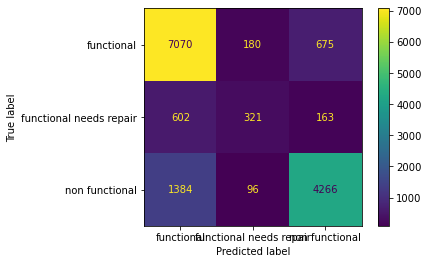

In [106]:
plot_confusion_matrix(final_model, X_test, y_test)

In [134]:
tot_func = sum(conf_mat[0, :])
tot_func_rep = sum(conf_mat[1, :])
tot_non_func = sum(conf_mat[2, :])

func = np.zeros((1, 3))
func_rep = np.zeros((1, 3))
non_func = np.zeros((1, 3))
for i in range(3):
    func[0, i] = conf_mat[0, i] / tot_func
    func_rep[0, i] = conf_mat[1, i] / tot_func_rep
    non_func[0, i] = conf_mat[2, i] / tot_non_func

prop_func = np.array([func[0,0],
                      func_rep[0,0],
                      non_func[0,0]])

prop_func_rep = np.array([func[0,1],
                          func_rep[0,1],
                          non_func[0,1]])

prop_non_func = np.array([func[0,2],
                          func_rep[0,2],
                          non_func[0,2]])

prop_non_func

array([0.0851735 , 0.15009208, 0.74242952])

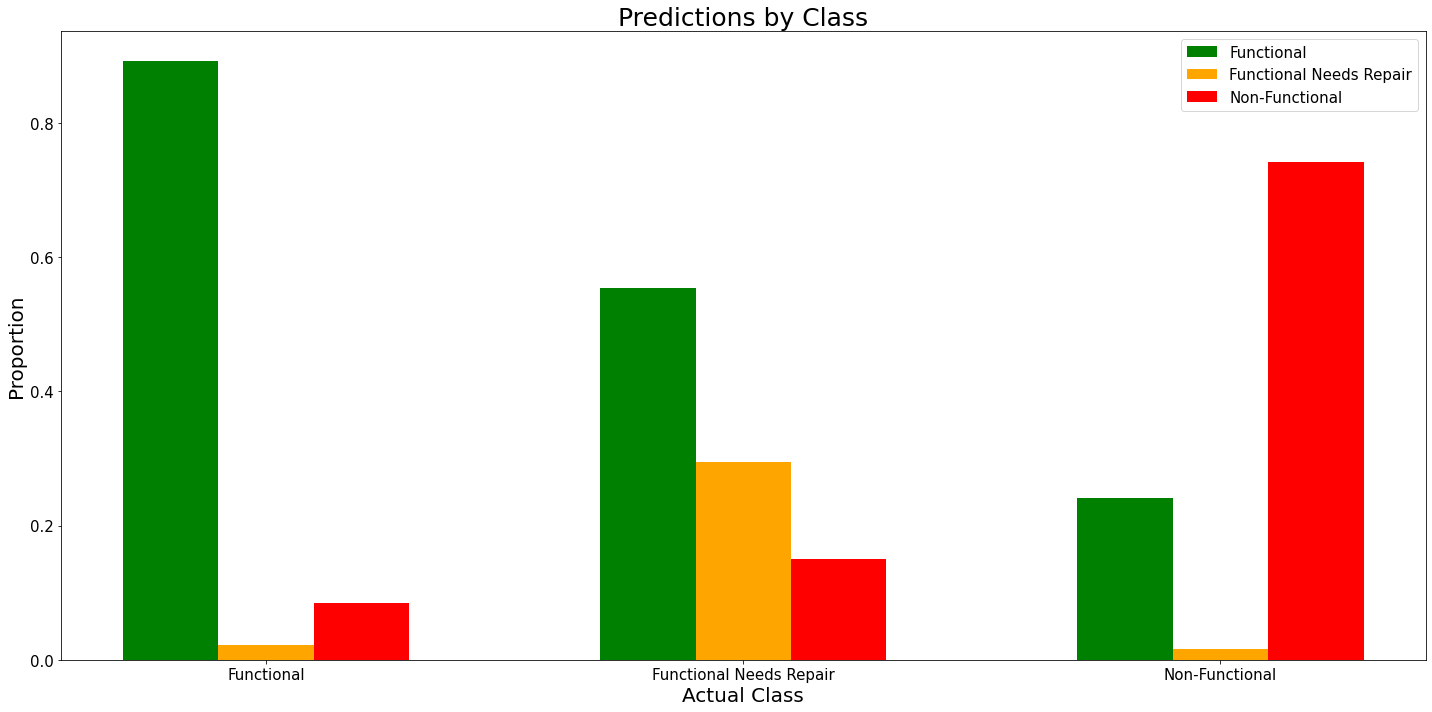

In [142]:
labels = ['Functional', 'Functional Needs Repair', 'Non-Functional']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width, prop_func, width, label='Functional', color='green')
rects2 = ax.bar(x, prop_func_rep, width, label='Functional Needs Repair', color='orange')
rects3 = ax.bar(x + width, prop_non_func, width, label='Non-Functional', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion', fontsize=20)
ax.set_xlabel('Actual Class', fontsize=20)
ax.set_title('Predictions by Class', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)

fig.tight_layout()

plt.savefig('images/preds_by_class.png', dpi=400)